In [26]:
"""
Cellule 1 : Chargement des données .npy
"""

import numpy as np

X_train = np.load("./data/X_train.npy")
y_train = np.load("./data/y_train.npy")
X_test  = np.load("./data/X_test.npy")
y_test  = np.load("./data/y_test.npy")

print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")

y_train = y_train.ravel()
y_test = y_test.ravel()


X_train shape : (200, 200)
X_test shape  : (200, 200)


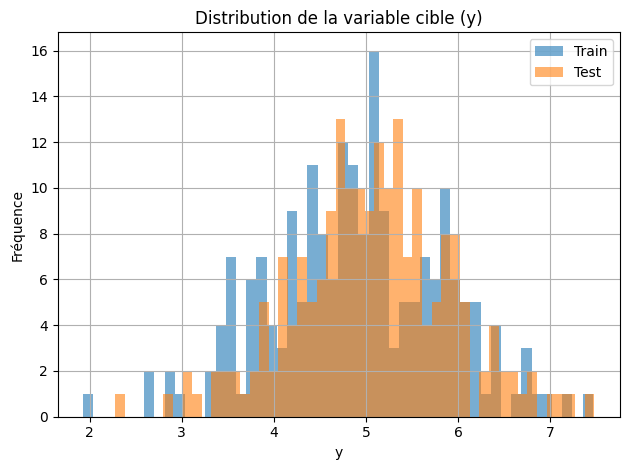

'\nCellule 2 : Split validation pour entraînement (stratégie propre)\n'

In [27]:
"""
Cellule 2 : Distribution de la variable cible
"""

import matplotlib.pyplot as plt

plt.hist(y_train, bins=50, alpha=0.6, label="Train")
plt.hist(y_test, bins=50, alpha=0.6, label="Test")
plt.title("Distribution de la variable cible (y)")
plt.xlabel("y")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./data_distribution.png")
plt.show()

"""
Cellule 2 : Split validation pour entraînement (stratégie propre)
"""





In [28]:
"""
Cellule 3 : Split du set d'entraînement
"""
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [29]:
"""
Cellule 4 : Modèle 1 : OLS (baseline)
"""

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ols = LinearRegression()
ols.fit(X_train, y_train)
y_test_pred_ols = ols.predict(X_test)

print("OLS — R² :", r2_score(y_test, y_test_pred_ols))
print("OLS — MSE :", mean_squared_error(y_test, y_test_pred_ols))
print("OLS — MAE :", mean_absolute_error(y_test, y_test_pred_ols))


OLS — R² : -9.918822989380713
OLS — MSE : 8.038314633956395
OLS — MAE : 2.342344109790829


In [30]:
"""
Cellule 5 : Modèle 2 : Ridge avec PCA
"""


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("ridge", Ridge())
])

param_grid_ridge = {
    "ridge__alpha": [0.1, 1.0, 10.0, 100.0]
}

ridge_grid = GridSearchCV(ridge_pipeline, param_grid_ridge, scoring="r2", cv=5, n_jobs=-1)
ridge_grid.fit(X_tr, y_tr)

print("RIDGE (avec PCA) validation R2 :", r2_score(y_val, ridge_grid.predict(X_val)))


RIDGE (avec PCA) validation R2 : 0.42647902260363535


In [31]:
"""
Cellule 6 : Modèle 3 : XGBoost avec PCA
"""

from xgboost import XGBRegressor

xgb_pipeline_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("xgb", XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42))
])

param_grid_xgb_pca = {
    "xgb__n_estimators": [300],
    "xgb__max_depth": [5],
    "xgb__learning_rate": [0.1],
    "xgb__subsample": [0.6],
    "xgb__colsample_bytree": [1.0]
}

xgb_grid_pca = GridSearchCV(xgb_pipeline_pca, param_grid_xgb_pca, scoring="r2", cv=5, n_jobs=-1)
xgb_grid_pca.fit(X_tr, y_tr)

print("XGB (avec PCA) validation R2 :", r2_score(y_val, xgb_grid_pca.predict(X_val)))


XGB (avec PCA) validation R2 : 0.0678901504007795


In [32]:
"""
Cellule 7 : Comparaison de 4 modèles (Ridge, Lasso, GBR, XGB sans PCA)
"""


from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor

models = {
    "ridge": Ridge(),
    "lasso": Lasso(max_iter=10000),
    "gbr": GradientBoostingRegressor(),
    "xgb": XGBRegressor(objective="reg:squarederror", n_jobs=-1)
}

param_grids = {
    "ridge": {"reg__alpha": [0.1, 1.0, 10.0, 100.0]},
    "lasso": {"reg__alpha": [0.0001, 0.001, 0.01, 0.1]},
    "gbr": {"reg__n_estimators": [100, 300], "reg__learning_rate": [0.05, 0.1], "reg__max_depth": [3, 5]},
    "xgb": {
        "reg__n_estimators": [300, 500],
        "reg__learning_rate": [0.05, 0.1],
        "reg__max_depth": [3, 5],
        "reg__subsample": [0.6, 1.0],
        "reg__colsample_bytree": [0.6, 1.0]
    }
}

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

best_models = {}

for name, model in models.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("reg", model)])
    search = GridSearchCV(pipe, param_grids[name], scoring="r2", cv=5, n_jobs=-1, verbose=1)
    search.fit(X_tr, y_tr)
    score = search.score(X_val, y_val)
    print(f"{name.upper()} validation R2 : {score:.4f}")
    best_models[name] = search.best_estimator_


Fitting 5 folds for each of 4 candidates, totalling 20 fits
RIDGE validation R2 : 0.7113
Fitting 5 folds for each of 4 candidates, totalling 20 fits
LASSO validation R2 : 0.9396
Fitting 5 folds for each of 8 candidates, totalling 40 fits
GBR validation R2 : 0.4877
Fitting 5 folds for each of 32 candidates, totalling 160 fits
XGB validation R2 : 0.5290


In [33]:
"""
Cellule 8 : Test final sur meilleur modèle (Lasso)
"""

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

final_model = best_models["lasso"]
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)

print("=== TEST SET ===")
print("R² :", r2_score(y_test, y_test_pred))
print("MSE :", mean_squared_error(y_test, y_test_pred))
print("MAE :", mean_absolute_error(y_test, y_test_pred))


=== TEST SET ===
R² : 0.9195566713927862
MSE : 0.05922147342954638
MAE : 0.20109215158889243


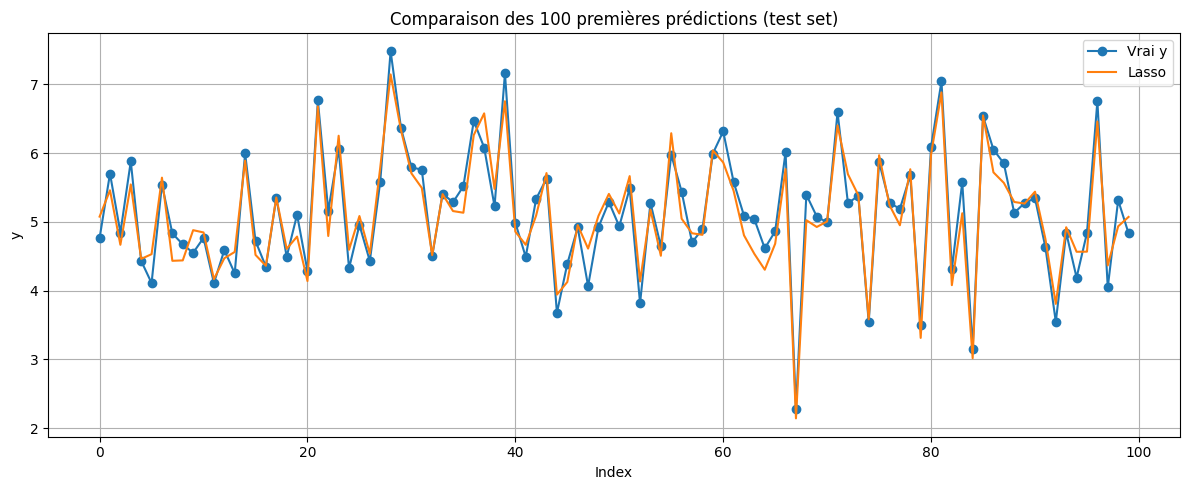

In [34]:
"""
Cellule 9 : Visualisation des prédictions
"""
plt.figure(figsize=(12, 5))
plt.plot(y_test[:100], label="Vrai y", marker='o')
plt.plot(y_test_pred[:100], label="Lasso", linestyle='-')
plt.title("Comparaison des 100 premières prédictions (test set)")
plt.xlabel("Index")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("./prediction.png")
plt.show()


In [35]:
"""
Cellule 10 : Tableau comparatif
"""
from sklearn.linear_model import LinearRegression

ols = LinearRegression().fit(X_train, y_train)
y_ols = ols.predict(X_test)

ridge = best_models["ridge"].fit(X_train, y_train)
y_ridge = ridge.predict(X_test)

xgb = best_models["xgb"].fit(X_train, y_train)
y_xgb = xgb.predict(X_test)

results = pd.DataFrame({
    "Modèle": ["OLS", "Ridge", "XGBoost", "Lasso"],
    "R²": [
        r2_score(y_test, y_ols),
        r2_score(y_test, y_ridge),
        r2_score(y_test, y_xgb),
        r2_score(y_test, y_test_pred)
    ],
    "MSE": [
        mean_squared_error(y_test, y_ols),
        mean_squared_error(y_test, y_ridge),
        mean_squared_error(y_test, y_xgb),
        mean_squared_error(y_test, y_test_pred)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_ols),
        mean_absolute_error(y_test, y_ridge),
        mean_absolute_error(y_test, y_xgb),
        mean_absolute_error(y_test, y_test_pred)
    ]
})

print(results)



    Modèle        R²       MSE       MAE
0      OLS -9.918823  8.038315  2.342344
1    Ridge  0.715260  0.209623  0.366483
2  XGBoost  0.623141  0.277439  0.416120
3    Lasso  0.919557  0.059221  0.201092


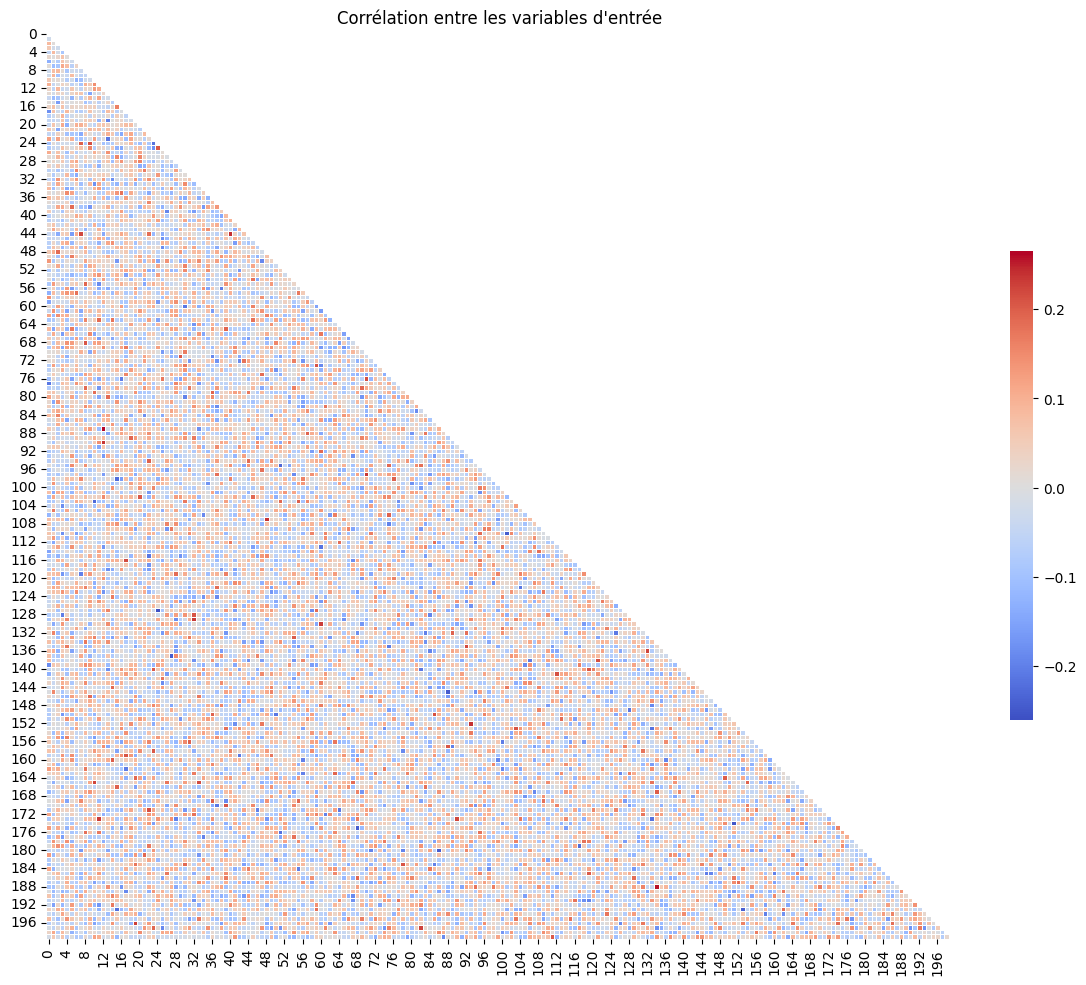

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = np.corrcoef(X_train.T)


mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

plt.title("Corrélation entre les variables d'entrée")
plt.tight_layout()
plt.savefig("./correlation_matrix.png")
plt.show()
